In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time, gmtime, sleep
import sys
sys.path.append("/home/jovyan/HSE-Bioinformatics")
sys.path.append("/home/jovyan/diploma_scripts/scripts")
from bio import *
import dcona_runs
import dcona
from tqdm.auto import tqdm; tqdm.pandas()
import telegram_send
import multiprocessing
import os

In [2]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [3]:
SHARED_PATH = Path('/home/jovyan/shared')
TCGA_PATH = SHARED_PATH / 'TCGA_data'
OUTPUT_PATH = SHARED_PATH / 'narek/outputs'
BRCA_DATA = SHARED_PATH / 'narek/Diplom2/data_BRCA'

TCGA_STUDY = 'TCGA-BRCA'
iso_type = "pan_cancer_exclusive_log2_FPM_DESeq2"
annotation = rt(BRCA_DATA/'annotation.tsv')

In [4]:
def adjust_permute(df):
    df = df.copy()
    df['AdjPermutePvalue'] = df['PermutePvalue'] / round(df.rank(axis=0)["PermutePvalue"]) * df.shape[0]
    return df.sort_values('AdjPermutePvalue')

def pvalue_cutoff(df, by: str, alpha: float = 0.05):
    return df.loc[df[by] <= alpha]

In [43]:
hyper_df = pd.read_csv(OUTPUT_PATH/"hypergeom/2_ts.csv", sep=",").sort_values('Diff', ascending=False)
ztest_df = rc(OUTPUT_PATH/'experiments/2/ztest_ts.csv')
ztest_df = adjust_permute(ztest_df)
# ztest_df = pvalue_cutoff(ztest_df, 'AdjPermutePvalue')
ztest_df = ztest_df.loc[ztest_df['Source'].isin(hyper_df['Molecule'])]

In [6]:
def plot_hypergeom(exp, inter, title, proportion=False):
    hyper_df = pd.read_csv(OUTPUT_PATH/f"hypergeom/{exp}_{inter}.csv", sep=",").sort_values('Diff', ascending=False)
    ztest_df = rc(OUTPUT_PATH/f"experiments/{exp}/ztest_{inter}.csv")
    ztest_df = adjust_permute(ztest_df)
    # ztest_df = pvalue_cutoff(ztest_df, 'AdjPermutePvalue')
    ztest_df = ztest_df.loc[ztest_df['Source'].isin(hyper_df['Molecule'])]


#     CORR_TRESHOLD = 0.3

    # Initial number of targets in Normal state
    isomiRs = ztest_df["Source"].unique()
    ref_targets_num = {isomiR: len(ztest_df.loc[
        (ztest_df["Source"] == isomiR) \
#         & (ztest_df["RefCorr"] < -CORR_TRESHOLD)
    ]) for isomiR in isomiRs}

    # Main analysis
    ztest_df = ztest_df.loc[ztest_df["AdjPermutePvalue"] < 0.05]

    # Correlation threshold condition
    isomiRs = ztest_df["Source"].unique()
#     ztest_df = ztest_df.loc[
#         ((ztest_df["RefCorr"] < -CORR_TRESHOLD) &
#             (ztest_df["ExpCorr"] > -CORR_TRESHOLD)) | \
#         ((ztest_df["RefCorr"] > -CORR_TRESHOLD) &
#             (ztest_df["ExpCorr"] < -CORR_TRESHOLD))
#     ]

    ztest_df["Targets_num"] = [0] * len(ztest_df)
    for isomiR in isomiRs:
        ztest_df.loc[ztest_df["Source"] == isomiR, "Targets_num"] = \
            len(ztest_df.loc[ztest_df["Source"] == isomiR])

    ztest_df = ztest_df.sort_values(by=["Targets_num", "Source"], ascending=False)
    isomiRs = list(ztest_df["Source"].unique())
    for isomiR in hyper_df["Molecule"]:
        if not isomiR in isomiRs:
            isomiRs.append(isomiR)

    # No correlation threshold condition
#     hyper_df = hyper_df.sort_values(by=["Diff"], ascending=False)
#     isomiRs = list(hyper_df["Molecule"])

    ztest_df.loc[ztest_df["Statistic"] < -1, "Statistic"] = -1.5
    ztest_df.loc[ztest_df["Statistic"] > 1, "Statistic"] = 1.5
    ztest_df["Statistic"] += 1.5
    ztest_df["Statistic"] /= 3
    ztest_df = ztest_df.sort_values(by=["Statistic"], ascending=False)
    ztest_df.index = np.arange(len(ztest_df))

    fig, ax = plt.subplots()

    labels = ["-".join(molecule.split("-")[1:]) for molecule in isomiRs]
    genes = list(ztest_df["Target"].unique())

    numeration = {isomiR: i for i, isomiR in enumerate(isomiRs)}

    bottom = [0] * len(isomiRs)
    for i, row in tqdm(ztest_df.iterrows(), total=ztest_df.shape[0]):
    #     print(i, len(ztest_df), row["Source"], row["Target"])
        bars = [0] * len(isomiRs)
        if not proportion:
            bars[numeration[row["Source"]]] = 1
        else:
            bars[numeration[row["Source"]]] = 1 / ref_targets_num[row["Source"]]
        ax.bar(labels, bars, bottom=bottom, color=cm.bwr(row["Statistic"]))
        if not proportion:
            bottom[numeration[row["Source"]]] += 1
        else:
            bottom[numeration[row["Source"]]] += 1 / ref_targets_num[row["Source"]]

    # ax.set_ylim([0, 70])

    # plt.ylabel("Число изменившихся корреляций")
    plt.ylabel(f"{'Пропорция' if proportion else 'Число'} изменившихся корреляций")
    plt.xticks(fontsize=8)
    plt.xticks(rotation=90)
    # plt.ylim((0, 200))

    cn = colors.Normalize(vmin=-1.5, vmax=1.5)
    sm = cm.ScalarMappable(norm=cn, cmap=cm.bwr)
    legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
    legend.ax.set_ylabel("Значение $Z_S(N, T)$", labelpad=-57)
    plt.tight_layout()
    plt.title(title)
    plt.savefig(OUTPUT_PATH/f"hypergeom/plots/{exp}_{inter}_changed_corrs{'_number' if proportion else ''}.png", dpi=400)
    # plt.savefig("../plots/isomiR_two-sided_changed_corrs.png", dpi=400)

In [68]:
data_to_plot = [
    ('2', 'ts', 'AGO2 | Luminal A | TargetScan'), 
    ('2', 'rna22', 'AGO2 | Luminal A | RNA22'), 
    ('6', 'ts', 'DROSHA | Luminal A | TargetScan'), 
    ('6', 'rna22', 'DROSHA | Luminal A | RNA22'), 
    ('9', 'ts', 'DGCR8 | Luminal A | TargetScan'), 
    ('7', 'rna22', 'DICER1 | Normal | RNA22')
]

  0%|          | 0/628 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/628 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/695 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/695 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/203 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/203 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/690 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/690 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/611 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/611 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_1104393/3592247526.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


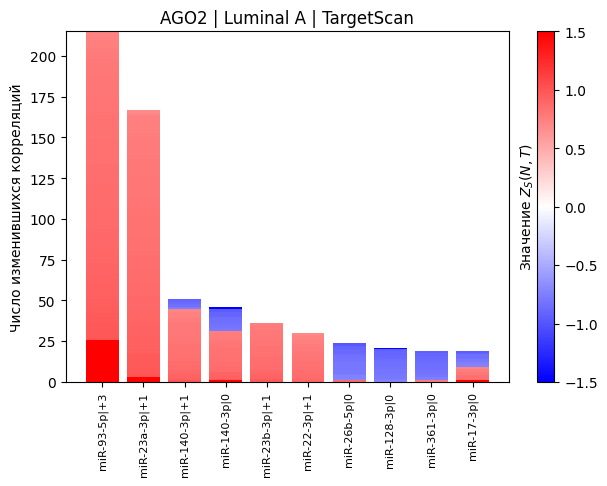

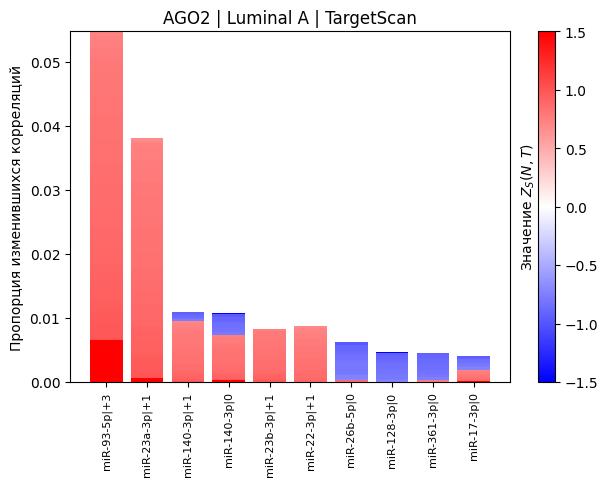

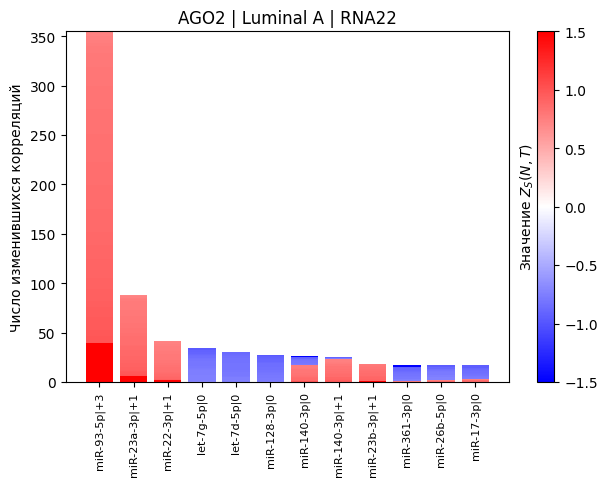

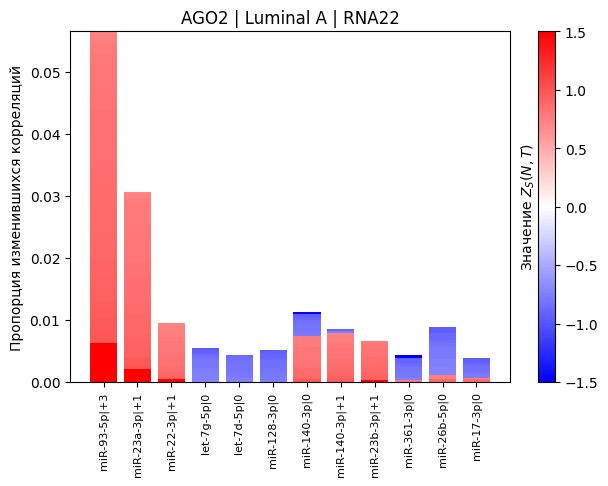

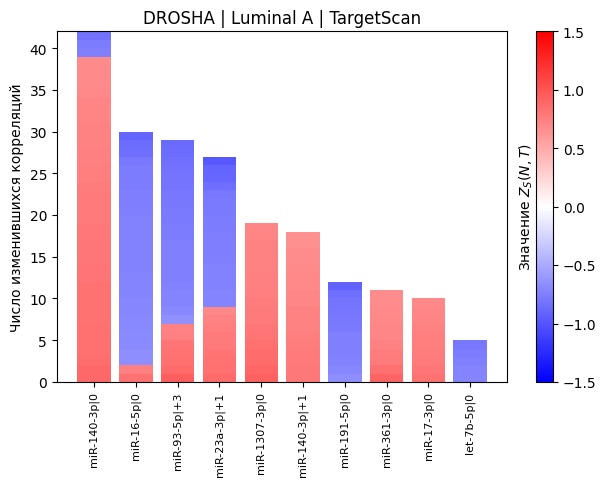

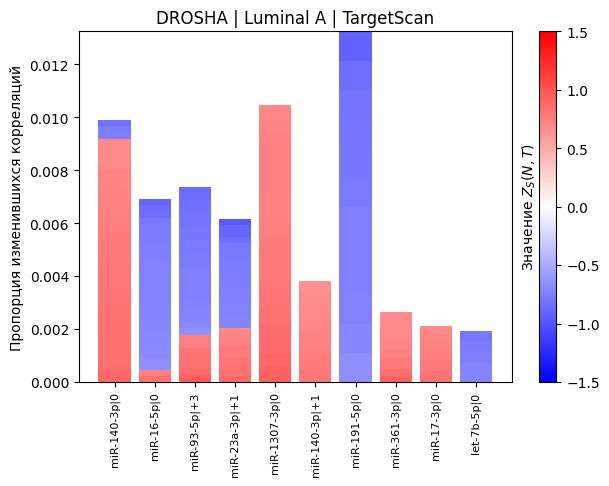

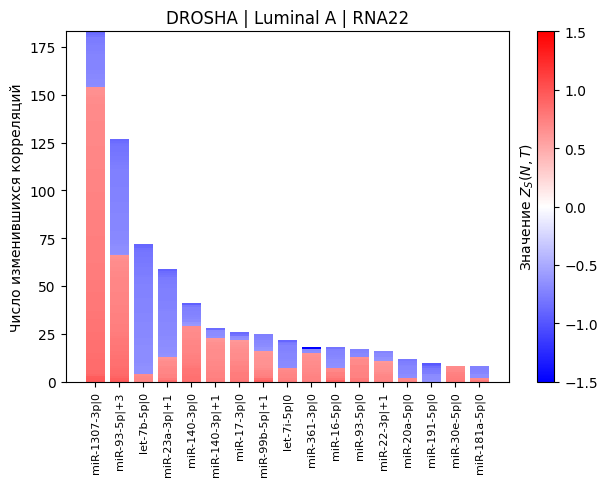

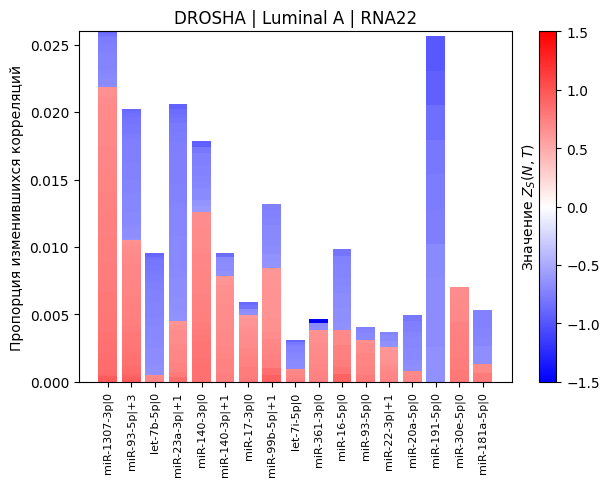

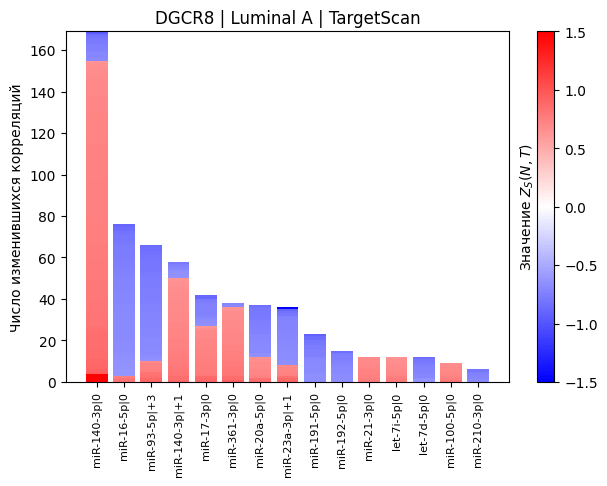

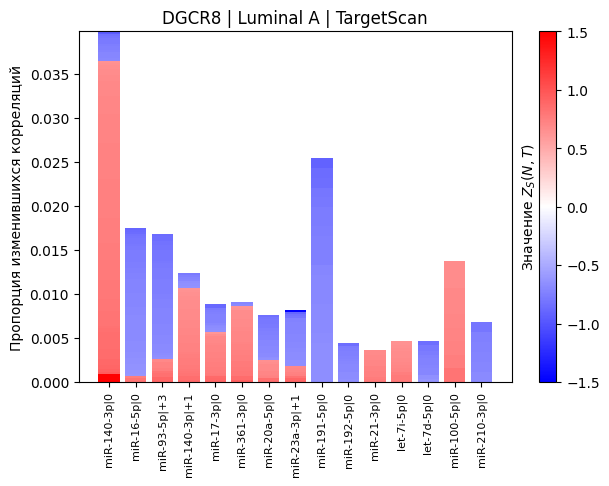

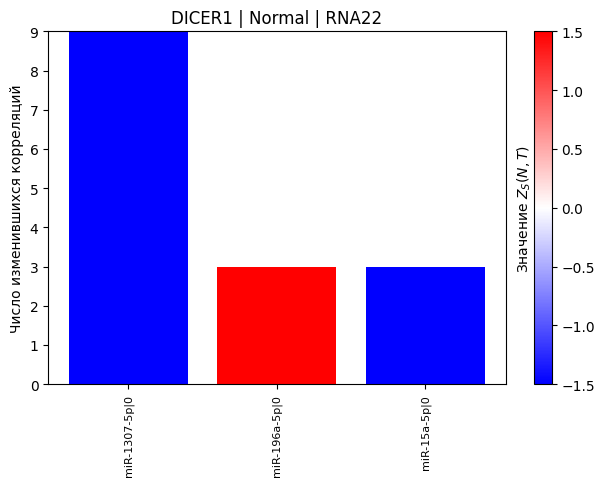

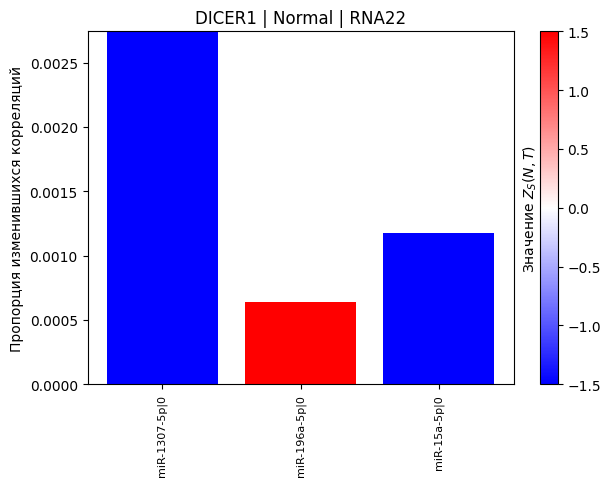

In [72]:
for exp, inter, title in data_to_plot:
    plot_hypergeom(exp, inter, title)
    plot_hypergeom(exp, inter, title, True)

  0%|          | 0/163 [00:00<?, ?it/s]

/tmp/ipykernel_39893/1010513360.py:83: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/163 [00:00<?, ?it/s]

/tmp/ipykernel_39893/1010513360.py:83: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/84 [00:00<?, ?it/s]

/tmp/ipykernel_39893/1010513360.py:83: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


  0%|          | 0/84 [00:00<?, ?it/s]

/tmp/ipykernel_39893/1010513360.py:83: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  legend = plt.colorbar(sm, ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


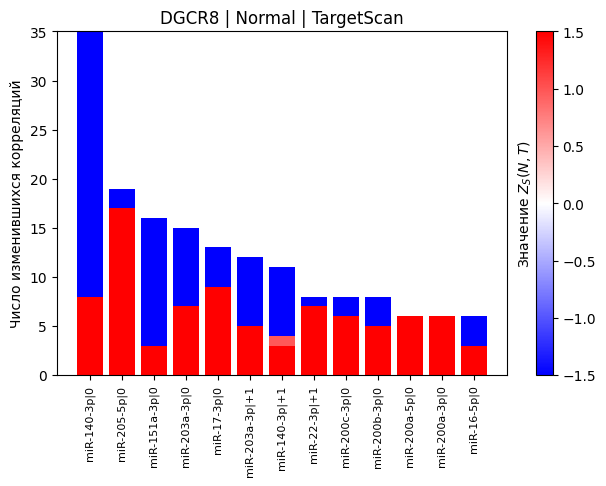

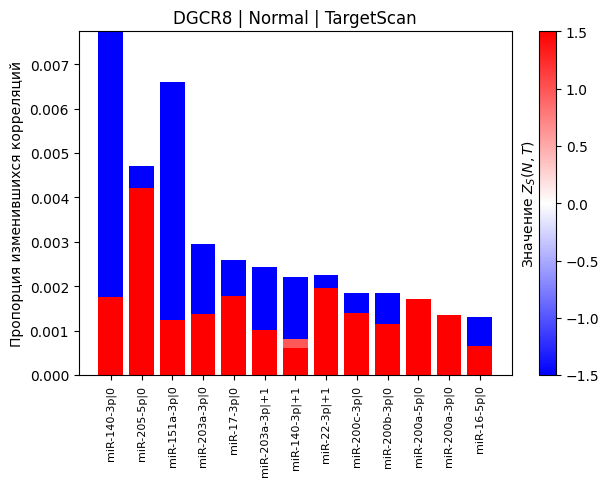

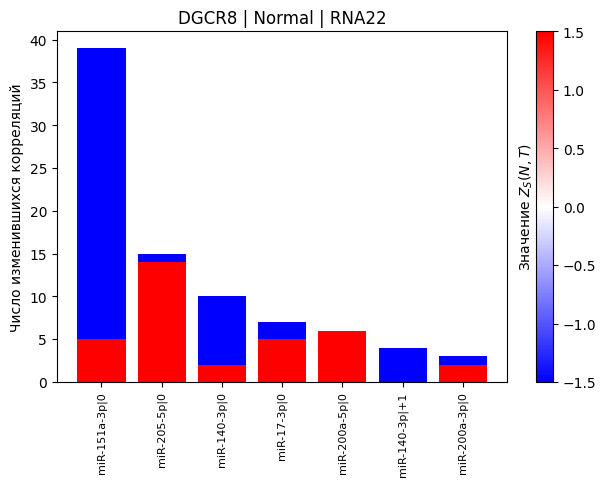

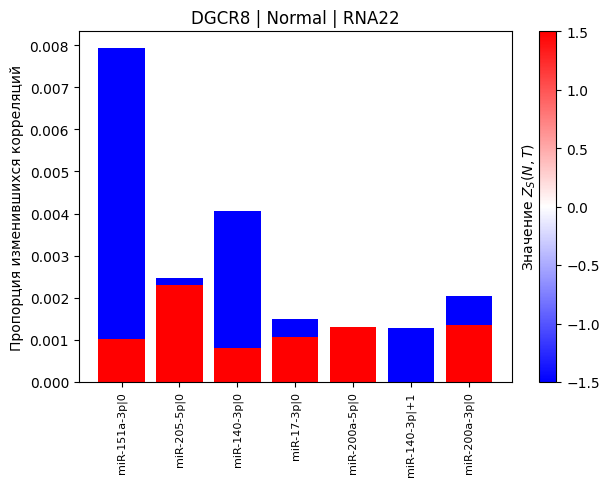

In [8]:
data_to_plot = [
    ('10', 'ts', 'DGCR8 | Normal | TargetScan'), 
    ('10', 'rna22', 'DGCR8 | Normal | RNA22'), 
]

for exp, inter, title in data_to_plot:
    plot_hypergeom(exp, inter, title)
    plot_hypergeom(exp, inter, title, True)